In [1]:
import numpy as np
import pandas as pd

# Plotly plotting support
import plotly.plotly as py

# import cufflinks as cf
# cf.go_offline() # required to use plotly offline (no account required).

import plotly.graph_objs as go
import plotly.figure_factory as ff

# Make the notebook deterministic 
np.random.seed(42)

# Basic Modeling

For this exercise we are going to use synthetic data to illustrate the basic ideas of model design.  Notice here that we are generating data from a linear model with Gaussian noise.

In [2]:
n = 100      # Number of records 

noise = 0.5  # Noise in observations (we wouldn't know this in real life)
m = 1.5      # The true slope (we wouldn't know this in real life) 
b = 3.0      # The true intercept (we wouldn't know this in real life)

# Make the data --------------------------
X = np.random.rand(n) * 4. - 2.
# The Y values are created using the secret model 
#      (We wouldn't have this in real-life either)

Y = m * X + b + np.random.randn(n) * noise

In [3]:
# Visualize the data ---------------------
raw_data = go.Scatter(name = "Data", x = X, y = Y, mode = 'markers')
py.iplot([raw_data], filename="L19-p1-01")

## Starting Simple


* We know how the data was created but let's imagine we did not.
* What is the simplest model for this data? 

Recall that we are trying to "model" the relationship between $x$ and $y$.  Let's focus on the class of **parametric** models that are functional relationships defined by a set of **parameters** $\theta$:

$${\large
f_\theta: x \rightarrow y
}
$$



--- 

<br/><br/><br/><br/>

### The constant function:

Here is a very simple model:

$$ {\large
f_\theta(x) = \theta
}
$$

Notice that this model is defined by a single number $\theta$.  How should we determine $\theta$?  

**What would be a good guess for $\theta$**?

1. 0
1. $\bar{x} = \frac{1}{n}\sum_{i=1}^n x_i$
1. $\bar{y} = \frac{1}{n}\sum_{i=1}^n x_i$



<br/><br/><br/><br/><br/>

---

**Proposal:** 

$${\large
\theta = \bar{y} = \frac{1}{n} \sum_{i=1}^n y_i
}$$

Why is this a good guess?

We can define our model in Python:

In [4]:
# Define our simple constant model:
def f_const(theta, x):
    return theta 

# Guess a value for theta
theta_guess = np.mean(Y)

# Make predictions for all of our training data
yhat = [f_const(theta_guess, x) for x in X]

## Visualizing the Fit

For this and the next lecture I am experimenting with Plotly.  It allows me to build more interactive web-based graphics.  (Let me know what you think.)

In [5]:
# Visualize the data ---------------------
theta_guess_line = go.Scatter(
    name="First Guess", 
    x = X, y = yhat, 
    mode = 'lines', line = dict(color = 'red')
)
py.iplot([raw_data, theta_guess_line], filename="L19-p1-02")

## Is this a good approximation of the data?   

---

<br/><br/><br/><br/><br/>

## Look at the Residuals

In [6]:
# Definethe residual lines segments, a separate line for each training point
residual_lines = [
    go.Scatter(x=[x,x], y=[y,yhat],
                       mode='lines', showlegend=False, line=dict(color='black', width = 0.5))
    for (x, y, yhat) in zip(X, Y, yhat)
]
# Combine the plot elements
py.iplot([raw_data, theta_guess_line] + residual_lines, filename="L19_p1_p02.1")

We can compute the residuals by computing the difference between the predicted value and the true value:

In [7]:
residuals = yhat - Y

In [8]:
# Plot.ly plotting code
py.iplot(go.Figure(
    data = [dict(x=X, y=residuals, mode='markers')],
    layout = dict(title="Residual Plot", xaxis=dict(title="X"), yaxis=dict(title="Residual"))
), filename="L19_p1_p02.2")

What do we see in the above plot?

----
<br/><br/><br/><br/>

The residual has a clear linear dependence on $X$.  This means that there is probably more that we could model.  Let's come back to that.

### The Residual Distribution

The residual distribution seems to be pretty uniform and not necessarily concentrated around 0.  However, it seems pretty symmetric. 

In [9]:
py.iplot(ff.create_distplot([residuals], group_labels=['Residuals']), filename="L19_p1_p02.3")

The residuals analysis suggests:
1. There is still linear structure that we can model. 
1. We don't appear to have any strong bias in our predictor


We still haven't answered the key question:

## How do we quantify how well a model fits the data? 

--- 

<br/><br/><br/><br/><br/><br/>

# Loss Functions and the Squared Loss

To answer these questions we need to define a **loss function** to measure how well the model approximates the data.  A very common loss function is the **squared loss** which measures the squared difference between what the model predicts $f_\theta(x)$ and the observed response $y$.  

$${\large
L(y, f_\theta(x)) = \left( y - f_\theta(x) \right)^2
}$$

The **squared loss** is the foundation of the **least squares** method which is widely used in function approximation and modeling and can be applied to a wide range of models (not just linear models).


If we have many data points (and hopefully we do) then we define the loss over the entire dataset as:

$${\large
L_D(\theta) = \frac{1}{n} \sum_{i=1}^n L(y_i, f_\theta(x_i))
}$$

Notice that in the above notation we have defined the loss $L_D(\theta)$ as a function of only the parameters $\theta$ and are assuming the model form $f$ and the data $D$ are fixed.  If we consider the squared loss we get:

$${\large
L_D(\theta) = \frac{1}{n} \sum_{i=1}^n \left( y_i -  f_\theta(x_i) \right)^2
}$$


--- 

<br/><br/><br/>
We can plot the **loss function** for our simple model and our best guess

In [10]:
# Single point loss function
def sq_loss(y, pred):
    return (y - pred)**2

In [11]:
# Loss over the entire dataset for a given thena
def loss(f, theta):
    return np.mean([sq_loss(y, f(theta, x)) for (x,y) in zip(X,Y)])

We can compute the loss for a bunch of different $\theta$ values.

In [12]:
# Generate a range of possible theta values (models)
theta_values = np.linspace(0, 5, 100)

# Compute the loss of each
loss_values = [loss(f_const, theta) for theta in theta_values]

We can then plot the loss on our data as function of $\theta$

In [13]:
## Plotting code ---------
loss_curve = go.Scatter(name="Loss Function", x = theta_values, y = loss_values, mode = 'lines')
best_guess = go.Scatter(name="Best Guess", x = [theta_guess], y = [loss(f_const, theta_guess)], 
                        mode = 'markers',
                        marker=dict(color="red", size=20))
layout = go.Layout(xaxis=dict(title=r"$\theta$"), yaxis=dict(title=r"Loss Value"))
fig = go.Figure(data = [loss_curve, best_guess ], layout = layout)
py.iplot(fig, filename="L19-p1-03")

**Observation:** *The loss function is a smooth quadratic curve.*

This is not an artifact of our data.  In general, when we combine the squared loss with a linear model (more on this later) we will get nice quadratic loss curves (potentially in many dimensions).

---

<br/><br/><br/><br/><br/><br/>




## Minimize the Loss with Calculus

<img src="convex_function.png" width="400px" style="float:right">


We guessed that best $\theta$ value for the model $f_\theta(x) = \theta$ would be $\theta = \frac{1}{n} \sum_{i=1}^n y_n$ (the red circle in the above figure).  This was a good guess!!  

However, a more general procedure would be to use calculus to minimize the loss function. 




**Beginners Convex Optimization Recipe:**
1. Take derivative of the loss function 
1. Solve for paramter values by setting derivative equal to zero

---
<br/><br/><br/><br/><br/>

Working through the calculations for our very simple constant function:

\begin{align*} 
\large\frac{\partial}{\partial \theta} L_D(\theta) 
& \large{ = \frac{1}{n} \sum_{i=1}^n \frac{\partial}{\partial \theta} \left( y_i -  f_\theta(x_i) \right)^2 }\\
& \large{= \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  f_\theta(x_i) \right) \frac{\partial}{\partial \theta} f_\theta(x_i) }\\
& \large{ = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  \theta \right)}
\end{align*}

where the last line comes from:

$$\large
f_\theta(x) = \theta \quad \Rightarrow \quad \frac{\partial}{\partial \theta} f_\theta(x_i) = 1
$$

Setting the derivative equal to zero we get:


\begin{align*}
\large 0 & \large{= \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  \theta \right)  }\\
\large 0 &\large{ = \frac{2}{n} \sum_{i=1}^n y_i -  \theta \frac{2 n}{n} }\\
\large{\theta \frac{2 n}{n}} & \large{ =\frac{2}{n} \sum_{i=1}^n y_i  } \\
\large \theta  & = \large \frac{1}{n} \sum_{i=1}^n y_i   =  \bar{y}
\end{align*}


Therefore the loss minimizing assignment to $\theta$ is the average value of $y$.

# Modeling the Line

You may recall from introductory math classes the equation of a line:

$$\large
y = m \, x + b
$$

a line is one of the simplest models we might use to represent the relationship between an input $x$ and an output $y$.  We could write this as the model:

$$\large
f_{(m,b)}(x) = m \, x + b
$$

This is a **parametric model** parameterized by $m$ and $b$.  Adopting our earlier notation we define $\theta = (m, b)$ and rewrite our improved model:

$$\large
f_\theta(x) = \theta_0 x + \theta_1
$$

Now that we have a new model how should we select our parameters?  We would like to minimize our loss but what does it look like. 



In [14]:
# Our new model
def f_line(theta, x):
    return theta[0] * x + theta[1]

Generate all combinations of $\theta_0$ and $\theta_1$ on a 20 by 20 grid.

In [15]:
# To visualize the loss I need to generate many theta0, theta1 pairs. 
# This is done using meshgrid
(theta0,theta1) = np.meshgrid(np.linspace(0,3,20), np.linspace(1,5,20))
theta_values = np.vstack((theta0.flatten(), theta1.flatten())).T

Compute the loss for each $\theta$

In [16]:
# Evaluating the loss for all theta values
loss_values = [loss(f_line, theta) for theta in theta_values]

Plot the $\theta$ values

In [17]:
# Here I make a 3d surface plot.  X, Y, and Z must all be _matrices_ 
# corresponding to the x, y, z values for each point on the x,y plane 
loss_surface = go.Surface(
    x = theta0, y = theta1,
    z = np.reshape(loss_values, theta1.shape)
)

# Axis labels
layout = go.Layout(
    scene=go.Scene(
        xaxis=go.XAxis(title='theta0'),
        yaxis=go.YAxis(title='theta1'),
        zaxis=go.ZAxis(title='loss'),
        aspectratio=dict(x=1.,y=1., z=1.)
    )
)
fig = go.Figure(data = [loss_surface], layout = layout)
py.iplot(fig, filename="L19-p1-04")

Spin the above plot and guess what might be optimal values for $\theta$ (and admire D3 WebGL enabled visualizations).  

**Notice:** *The plot is quadratic like the earlier 1-dimensional loss function.*


## Minimizing the Loss Function

Let's now try to derive the minimizing values for our parameters:

\begin{align*}
\large \frac{\partial}{\partial \theta_0} L_D(\theta) 
&\large = \frac{1}{n} \sum_{i=1}^n \frac{\partial}{\partial \theta_0} \left( y_i -  f_\theta(x_i) \right)^2 \\
&\large = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  f_\theta(x_i) \right) \frac{\partial}{\partial \theta_0} f_\theta(x_i) \\
&\large = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i - \left(\theta_0 x_i + \theta_1 \right) \right) x_i
\end{align*}

where the last line comes from 

$$ \large
f_\theta(x) = \theta_0 x + \theta_1 \quad \Rightarrow \quad \frac{\partial}{\partial \theta_0} f_\theta(x) = x
$$  

Taking the derivative with respect to $\theta_1$

\begin{align*}
\large \frac{\partial}{\partial \theta_1} L_D(\theta) 
&\large = \frac{1}{n} \sum_{i=1}^n \frac{\partial}{\partial \theta_1} \left( y_i -  f_\theta(x_i) \right)^2 \\
&\large = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  f_\theta(x_i) \right) \frac{\partial}{\partial \theta_1} f_\theta(x_i) \\
&\large = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  \left(\theta_0 x_i + \theta_1\right) \right)
\end{align*}

where the last line comes from 

$$ \large
f_\theta(x) = \theta_0 x + \theta_1 \quad \Rightarrow \quad \frac{\partial}{\partial \theta_1} f_\theta(x) = 1
$$  




Setting both derivatives equal to zero we get the following system of equations:

\begin{align*}
\large 0 & \large  = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  \theta_0 x_i - \theta_1 \right) x_i \\
\large 0 & \large  = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  \theta_0 x_i - \theta_1 \right)
\end{align*}





We can do some algebra to make things a bit clearer:


\begin{align*}
\large \sum_{i=1}^n  x_i y_i  & \large =   \theta_0  \sum_{i=1}^n  x_i x_i + \theta_1  \sum_{i=1}^n  x_i \\
\large \sum_{i=1}^n y_i  & \large =   \theta_0  \sum_{i=1}^n  x_i + \theta_1 n
\end{align*}

To simplify the math we can define constants (statistics computed from the data directly):

\begin{align*}
\large C_1 & = \large \sum_{i=1}^n  x_i y_i  \quad & \large C_2  &= \large  \sum_{i=1}^n  x_i x_i \\
\large C_3 & = \large \sum_{i=1}^n  x_i \quad & \large  C_4 & \large = \sum_{i=1}^n y_i 
\end{align*}

Substituting the constants it becomes clear that we have a classic system of linear equations:

\begin{align*}
\large C_1 & = \large  \theta_0  C_2 + \theta_1  C_3 \\
\large C_4 & = \large \theta_0  C_3 + \theta_1 n
\end{align*}

Which we can solve analytically.  

## _Bonus:_ Solving Equations Symbolically

However, because algebra is tedious and we are data scientists who use technology to tackle problems (and make our lives easier) let's make a symbolic algebra library do the tricky work for us:

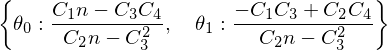

In [18]:
import sympy

# Define the variables (symbols) that we will use in our equation
theta0 = sympy.Symbol("theta0")
theta1 = sympy.Symbol("theta1")
c1 = sympy.Symbol("C1")
c2 = sympy.Symbol("C2")
c3 = sympy.Symbol("C3")
c4 = sympy.Symbol("C4")
n = sympy.Symbol("n")

# Solve the system of equations (eq = 0) for theta0 and theta1
theta_hats_symb = sympy.solve(
    [
        theta0 * c2 + theta1 * c3 - c1, # = 0
        theta0 * c3 + theta1 * n - c4  # = 0
    ], 
    [theta0, theta1])


# Print the answer (so pretty)
sympy.init_printing()
theta_hats_symb

Okay, so the above equation was pretty easy.  However, as we move to more complex models we will quickly find that both computing the derivatives and even solving them will require sophisticated analytic and numeric machinery.  

**The combination of symbolic differentiation and numerical optimization have been at the heart of recent advances in AI.**

--- 

<br/><br/><br/><br/><br/>

We can now compute the actual numerical values for the algebraic expressions above. Recall:

\begin{align*}
\large C_1 & = \large \sum_{i=1}^n  x_i y_i  \quad & \large C_2  &= \large  \sum_{i=1}^n  x_i x_i \\
\large C_3 & = \large \sum_{i=1}^n  x_i \quad & \large  C_4 & \large = \sum_{i=1}^n y_i 
\end{align*}

In [19]:
# Compute the actual numerical values for all the constants
subs = {
    c1: np.sum(X * Y),
    c2: np.sum(X * X),
    c3: np.sum(X),
    c4: np.sum(Y),
    n: len(X)
}

# For each theta value substitute the numerical values for the constans 
# and evaluate the expression
theta_hat = np.array([float(theta_hats_symb[theta0].evalf(subs=subs)), 
         float(theta_hats_symb[theta1].evalf(subs=subs))])
print(theta_hat)

[ 1.44252835  2.99260477]


We have just computed the "optimal" parameters for our original model. Returning to our earlier plot lets place the solution on the loss suface:

In [20]:
theta_hat_point = go.Scatter3d(
    x = [theta_hat[0]],
    y = [theta_hat[1]],
    z = [loss(f_line, theta_hat)],
    mode = 'markers', 
    marker = dict(color='red')
)
loss_surface.opacity = 0.9
fig = go.Figure(data = [loss_surface, theta_hat_point], layout = layout)
py.iplot(fig, filename="L19-p1-05")

We can also plot the line defined by these parameters:

In [21]:
# Define my model:
yhat = [f_line(theta_hat, x) for x in X]

# Visualize the data ---------------------
theta_line = go.Scatter(name="Linear Model", x = X, y = yhat, mode = 'lines',
    line = dict(color = 'red')
)
theta_guess_line.line.color = "pink"
residual_lines = [
    go.Scatter(x=[x,x], y=[y,yhat],
                       mode='lines', showlegend=False, line=dict(color='black', width = 0.5))
    for (x, y, yhat) in zip(X, Y, yhat)
]
py.iplot([raw_data, theta_guess_line, theta_line] + residual_lines, filename="L19-p1-06")

## Is this a better fit?

---
<br/><br/><br/>



In [22]:
residuals = yhat - Y
# Plot.ly plotting code
py.iplot(go.Figure(
    data = [dict(x=X, y=residuals, mode='markers')],
    layout = dict(title="Residual Plot", xaxis=dict(title="X"), yaxis=dict(title="Residual"))
), filename="L19_p1_p07")

In [23]:
py.iplot(ff.create_distplot([residuals], group_labels=['Residuals'],bin_size=0.2), 
         filename="L19_p1_p08")


---

# Quick Review


1. We introduced **parametric functions** as a basic modeling primitive
1. We introduced the **loss function** and in particular the **squared** loss to determine how well our model approximates our data.
1. We then used calculus to determine the model parameters that **minimize the loss function**

We will now generalize these ideas to the **parametric** function of a hyperplane.  

<br/><br/><br/><br/>


---

# Linear Model Family

The **linear model** is a generalization of our earlier two dimensional $y = m x + b$ model:

$$ \large
f_\theta(x) = \sum_{j=1}^p \theta_j x_j
$$

**Note:**
1. This is the model for a **single data point** $x$
1. The data point is **$p$-dimensional**
1. The subscript $j$ is indexing each of the $p$ dimensions

To simplify the presentation we will use the following vector notation:

$$ \large
f_\theta(x) =  x^T \theta
$$

You can see this in the following figure:

<img src="vector_dot.png" width="400px">

As we will see, shortly, this is a **very expressive parametric model**.  

In previous lectures we derived the **Least Squares** parameter values for this model.  Let's derive them once more.

## Matrix Notation

Before we proceed we need to define some new notation to describe the entire dataset.  We introduce the design (covariate) matrix $X$ and the response matrix (vector) $Y$ which encode the data:

<img src="design_matrix.png" width="400px">

**Notes:**
1. The **rows** of $X$ correspond to records (e.g., users in our database)
1. The **columns** of $X$ correspond to **features** (e.g., the age, income, height).
1. **CS and Stats Terminology Issue (p=d):** In statistics we use $p$ to denote the number of columns in $X$ which corresponds to the number of *parameters* in the corresponding linear model.  In computer science we use $d$ instead of $p$ to refer to the number of columns.  The $d$ is in reference to the *dimensionality* of each record.  You can see the differences in focus on the model and the data. If you get confused just flip the paper (or your computer) upside down and it will make more sense.



# The Least Squares Loss Objective

We can write the loss using the matrix notation:

\begin{align}
\large L_D(\theta) 
& \large = 
\frac{1}{n}\sum_{i=1}^n \left(Y_i -  f_\theta(X_i)\right)^2 \\
& \large = 
\frac{1}{n}\sum_{i=1}^n \left(Y_i -  X_i \theta \right)^2 \\
& \large = 
\frac{1}{n}\left(Y -  X \theta \right)^T \left(Y -  X \theta \right) 
\end{align}

Note that the last line $X_i \theta$ is the dot product of the 

<img src="matrix_dot.png" width="400px">

We can further simply the last expression by expanding the product:

\begin{align} \large
L_D(\theta) 
& \large = 
\frac{1}{n}\left(Y -  X \theta \right)^T \left(Y -  X \theta \right) \\
& \large = 
\frac{1}{n}\left(Y^T \left(Y -  X \theta \right) -  \left(X \theta\right)^T \left(Y -  X \theta \right) \right) \\
& \large  = 
\frac{1}{n}\left( 
   Y^T Y -  Y^T X \theta  - \left(X \theta \right)^T Y + \left(X \theta \right)^T  X \theta 
\right) \\
& \large =
\frac{1}{n} \left( 
 Y^T Y -  2 Y^T X \theta + \theta^T  X^T  X \theta 
\right)
\end{align}

**Note:** Because $\left(X \theta \right)^T Y$ is a scalar it is equal to its transpose $Y^T X \theta$ 
and therefore $- Y^T X \theta  - \left(X \theta \right)^T Y  = -2 Y^T X \theta$.



<br/><br/><br/>

# Computing the Loss Minimizing $\theta$ 
Recall our goal is to compute:

\begin{align} \large
\hat{\theta} = \arg \min_\theta L(\theta)
\end{align}


Which we can compute by taking the **gradient** of the loss and setting it equal to zero.


\begin{align} \large
\nabla_\theta L(\theta) 
& \large =
\frac{1}{n} \left( 
 \nabla_\theta Y^T Y -  \nabla_\theta 2 Y^T X \theta + \nabla_\theta \theta^T  X^T  X \theta 
\right) \\
& \large =
\frac{1}{n} \left( 
 0 -  2 X^T Y  +  2 X^T  X \theta 
\right) 
\end{align}

The above gradient derivation uses the following identities:
1. $\large \nabla_\theta \left( A \theta  \right) = A^T$
1. $\large \nabla_\theta \left( \theta^T A \theta \right) = A\theta + A^T \theta$ and $\large A = X^T X$ is symmetric

Setting the gradient equal to zero we get the famous **Normal Equations**:

$$\large
X^T  X \theta =  X^T Y
$$



$$\large
 \theta = \left(X^T  X\right)^{-1} X^T Y
$$




# Connection to the MLE


We can write a probabilistic model of the data:

$$ \large
Y = x^T \theta + \epsilon_\text{noise}
$$

where we assume:

$$ \large
\epsilon_\text{noise} \sim \textbf{Normal}\left(0, \sigma_\text{noise} \right)
$$

which implies:

\begin{align} \large
Y \sim \textbf{Normal}\left(x^T \theta, \sigma_\text{noise} \right)
\end{align}

If we assume the data are **i**ndependent and **i**dentically **d**istributed (iid) according to this model then the Maximum Likelihood parameter $\theta$ can be written as:

\begin{align}\large
\hat{\theta}_\text{MLE} 
&\large = \arg \max_\theta \log 
\left( \prod_{i=1}^n N\left(y_i; \,\, x_i^T \theta, \, \sigma_\text{noise} \right) \right) \\
&\large = \arg \min_\theta -\log 
\left( \prod_{i=1}^n N\left(y_i; \,\, x_i^T \theta, \, \sigma_\text{noise} \right) \right) \\
&\large =\arg \min_\theta 
\left( \sum_{i=1}^n -\log N\left(y_i; \,\, x_i^T \theta, \, \sigma_\text{noise} \right) \right) \\
&\large =\arg \min_\theta 
\left( \sum_{i=1}^n -\log \left( \frac{1}{\sqrt{2\sigma_\text{noise}^2\pi}} 
\exp \left(- \frac{\left(y_i - x_i^T \theta\right)^2}{2\sigma_\text{noise}^2} \right) \right) \right) \\
&\large =\arg \min_\theta 
 \sum_{i=1}^n  
 \frac{\left(y_i - x_i^T \theta\right)^2}{2\sigma_\text{noise}^2} \\
&\large =\arg \min_\theta 
\sum_{i=1}^n \left(y_i - x_i^T \theta\right)^2\\
&\large = \hat{\theta}_\text{LS}
\end{align}

**Notice:** 
1. did not need to assume $f_\theta(x) = x^T\theta$
1. we did need to assume **additive iid Gaussian noise** (reasonable?)


---
<br/><br/><br/><br/><br/>


# The Normal Equation

The normal equations define the least squares optimal parameter value  $\hat{\theta}$ for the linear regression model:

$$\large
 \hat{\theta} = \left(X^T  X\right)^{-1} X^T Y
$$

and have the pictorial interpretation of the matrices:

<img src="normal_equations.png" width="400px">

It is worth noting that for common settings where $n >> p$ (i.e., there are many records and only a few dimensions) the matrix $X^T X$ and $X^T Y$ are small relative to the data.  That is they summarize the data.


# Working with the Normal Equation

Now that we have the normal equation let's apply it to compute the optimal $\theta$ for our toy dataset. 

In [24]:
# Because X is 1 dimensional ... we need to use scalar inversion
theta_hat = (X.T @ X)**-1 * (X.T @ Y)
print(theta_hat)

1.1904575072


Plotting our least-squares regression line:

In [25]:
yhat = X * theta_hat

# Visualize the data ---------------------
normal_equation_line = go.Scatter(name="Normal Equation", x = X, y = yhat, mode = 'lines',
    line = dict(color = 'red')
)
py.iplot([raw_data, normal_equation_line], filename="L19_p1_p09")

**Stuck on the origin! Why?**

---
<br/><br/><br/><br/><br/><br/>


# The Bias (Intercept) Term
Remember our general linear model: 

$$ \large
f_\theta(x) = \sum_{j=1}^p \theta_j x_j
$$

doesn't have the **"bias"** term $b$ we had in our equation for a line:

$$ \large
y = m x + b
$$  


**Can we manipulate the _data_ to add a bias term to our model?**

<br/><br/><br/><br/><br/>

---

We begin our journey into **feature engineering** by adding an extra **constant** (typically 1) to each record:

<img src="adding_bias_term.png" width="400px">

This extra **feature** will allow our general linear model to represent a **bias** term.

We typically denote feature transformation $\phi(X)$  (**fea**ture transformation?).  For notational convenience I will occasionally write $\Phi = \phi(X)$.



In [26]:
def phi(x):
    return np.array([x, 1.])

Phi = np.array([phi(x) for x in X]) # more efficient: Phi = np.vstack((X, np.ones(n))).T
Phi[:5,]

array([[-0.50183952,  1.        ],
       [ 1.80285723,  1.        ],
       [ 0.92797577,  1.        ],
       [ 0.39463394,  1.        ],
       [-1.37592544,  1.        ]])

Using the normal equations again:

In [27]:
theta_hat = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ Y
print(theta_hat)

[ 1.44252835  2.99260477]


## A better way to solve

A more numerically stable and efficient way to compute $A^{-1} b$ is to use `np.linalg.solve` which computes the solution to $A \theta = b$ rather than first computing inverse of $A$ and then multiplying by $b$.

In [28]:
theta_hat = np.linalg.solve(Phi.T @ Phi, Phi.T @ Y)
print(theta_hat)

[ 1.44252835  2.99260477]


Plotting the fit once more.  Notice this time  `yhat` (i.e., $\hat{y}$) is computed using `Phi` (i.e., $\Phi$) instead of `X`.

In [29]:
yhat = Phi @ theta_hat # Phi instead of X

# Visualize the data ---------------------
normal_equation_line2 = go.Scatter(name="Normal Equation", x = X, y = yhat, mode = 'lines',
    line = dict(color = 'red')
)
py.iplot([raw_data, normal_equation_line2], filename="L19_p1_p10")

**Success! **

---

## Moving to a Higher Dimensional Plane

Something interesting just happened.  The linear model went from **one** dimension to **two** dimensions.  We added a **feature** (i.e., a dimension) to each record. In a sense we took points on the `(x,y)` plane above and moved them into 3-dimensions: `(x, 1, y)`.

We can actually plot the data in 3 dimensions and see the corresponding plane of best fit:

In [30]:
raw3d = go.Scatter3d(
    name = "Raw Data",
    x = Phi[:,0],
    y = Phi[:,1],
    z = Y,
    mode = 'markers',
    marker = dict(size=3)
)

(u,v) = np.meshgrid(np.linspace(-3,3,20), np.linspace(-3,3,20))
coords = np.vstack((u.flatten(),v.flatten())).T
ycoords = coords @ theta_hat

fit_plane = go.Surface(
    name = "Fitting Hyperplane",
    x = np.reshape(coords[:,0], (20,20)),
    y = np.reshape(coords[:,1], (20,20)),
    z = np.reshape(ycoords, (20,20)),
    opacity = 0.8,
    cauto = False,
    showscale = False,
    colorscale = [[0, 'rgb(255,0,0)'], [1, 'rgb(255,0,0)']]
)

origin = go.Scatter3d(
    name = "Origin (0,0,0)",
    x = [0],
    y = [0],
    z = [0],
    mode = 'markers', 
    marker = dict(color='black')
)

data_plane = go.Mesh3d(
    name = "2D Plot",
    x = [-3,3,3,-3],
    y = [1,1,1,1],
    z = [-10,-10,10,10],
    i = [0,1],
    j = [1,2],
    k = [3,3],
    opacity = 0.5,
    color = 'gray'
)

layout = go.Layout(
    scene=go.Scene(
        xaxis=go.XAxis(title='X'),
        yaxis=go.YAxis(title='Bias'),
        zaxis=go.ZAxis(title='Y'),
        camera=dict(eye=dict(x=0, y=-1, z=0))
    )
)

loss_surface.opacity = 0.9
fig = go.Figure(data = [raw3d, fit_plane, origin, data_plane], layout = layout)
py.iplot(fig, filename="L19_p1_p11")

Spin the above plot around, because it is pretty and also you will learn something.

**Notice:** 
1. The **red** plane is the plane corresponding to the model which passes through the points.
1. The **red** plane still passes through the origin (the big black circle).
1. The **gray** plane is the plane corresponding to the 2D plot in which the data originally lived.  
1. The intersection of the **red** and **gray** planes is the line of best fit with the bias term added!

You will notice that our data lives on the plane 3 dimensions and that the plane (in red) passes through the origin. 

This is a key theme with linear regression. That is by transforming the input we can often make complex data live on a plane that passes through the origin.

## A Note on the Bias Term

The **bias** term can be crucial for modeling data.  Most software packages will have an option to add a bias term to the model.  This is often implemented by transforming the input data though one has to be careful about adding how the bias term is treated in certain model tuning procedures (e.g., regularization which we will cover shortly).

# Linear Regression Software

In practice it is generally better to use existing software packages for linear regression.  In Python, [scikit-learn](http://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) is the standard package for regression.  

![scikit-learn logo](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)

Here we will take a very brief tour of how to use scikit-learn for regression.  Over the next few weeks we will use scikit-learn for a range of different task.

### Fit a Model

In [31]:
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=True)

reg.fit(np.array([X]).T, Y)
print("Slope:", reg.coef_)
print("Intercept:", reg.intercept_)

Slope: [ 1.44252835]
Intercept: 2.99260477199


### Make Predictions

In [32]:
yhat = reg.predict(np.array([X]).T)
py.iplot([raw_data, dict(x=X, y=yhat, name="Scikit Fit")], filename="L19_p1_p12")

Next we will explore the art and science of Featue Engineering.